# Deep Learning
## Assignment 3
Previously in assignment2.ipynb, we trained a logistic regression and a neural network model.
The goal of this assignment is to explore regularization techniques.

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle

%matplotlib inline

First reload the data we generated in assignment1.ipynb.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
data as a flat matrix,
labels as float 1-hot encodings.

In [3]:
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE
NUM_LABELS = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_PIXELS)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(NUM_LABELS) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

## Problem 1
Let's introduce and tune L2 regularization for both logistic and neural network models. L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, we can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve our validation / test accuracy.

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000
l2_beta = 0.01

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_labels = tf.constant(train_labels[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight matrix will be initialized 
    # using random values following a (truncated) normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, NUM_LABELS],
                                              stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    biases = tf.Variable(tf.zeros([NUM_LABELS]))
  
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases. We compute the softmax and cross-entropy
    # (it's one operation in TensorFlow, because it's very common, and it can be optimized). We take the average
    # of this cross-entropy across all training examples: that's our loss.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
            + l2_beta * tf.nn.l2_loss(weights)
  
    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report accuracy figures as we train.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [6]:
num_steps = 801

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the biases. 
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        if (step % 100 == 0):
            print('Loss at step %d: %f' % (step, l))
            print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 2.323459
Training accuracy: 14.9%
Validation accuracy: 65.1%
Loss at step 100: 0.708942
Training accuracy: 83.8%
Validation accuracy: 81.7%
Loss at step 200: 0.688805
Training accuracy: 84.5%
Validation accuracy: 81.9%
Loss at step 300: 0.682661
Training accuracy: 84.7%
Validation accuracy: 82.0%
Loss at step 400: 0.680448
Training accuracy: 84.7%
Validation accuracy: 82.0%
Loss at step 500: 0.679551
Training accuracy: 84.8%
Validation accuracy: 82.1%
Loss at step 600: 0.679143
Training accuracy: 84.8%
Validation accuracy: 82.1%
Loss at step 700: 0.678935
Training accuracy: 84.9%
Validation accuracy: 82.1%
Loss at step 800: 0.678816
Training accuracy: 84.9%
Validation accuracy: 82.1%
Test accuracy: 88.8%


Let's now switch to stochastic gradient descent training instead, which is much faster.
The graph will be similar, except that instead of holding all the training data into a constant node, we create a Placeholder node which will be fed actual data at every call of `session.run()`.

In [7]:
BATCH_SIZE = 128
HIDDEN_NODES = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_PIXELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    l2_beta = tf.placeholder(tf.float32)  # factor for regularization penalty
  
    # Variables.
    w1 = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, HIDDEN_NODES],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b1 = tf.Variable(tf.zeros([HIDDEN_NODES]))
    w2 = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b2 = tf.Variable(tf.zeros([NUM_LABELS]))
  
    # Training computation.
    hidden1 = tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1)
    logits = tf.matmul(hidden1, w2) + b2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
            + l2_beta * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2))
  
    # Optimizer. 
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden1_valid, w2) + b2)
    hidden1_test = tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1)
    test_prediction = tf.nn.softmax(tf.matmul(hidden1_test, w2) + b2)

Let's run it:


In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, l2_beta: 0.005}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.326218
Minibatch accuracy: 7.8%
Validation accuracy: 39.6%
Minibatch loss at step 500: 0.672074
Minibatch accuracy: 89.1%
Validation accuracy: 84.3%
Minibatch loss at step 1000: 0.736165
Minibatch accuracy: 82.8%
Validation accuracy: 84.2%
Minibatch loss at step 1500: 0.492880
Minibatch accuracy: 89.1%
Validation accuracy: 85.2%
Minibatch loss at step 2000: 0.517733
Minibatch accuracy: 92.2%
Validation accuracy: 84.9%
Minibatch loss at step 2500: 0.627064
Minibatch accuracy: 85.9%
Validation accuracy: 84.5%
Minibatch loss at step 3000: 0.658148
Minibatch accuracy: 85.9%
Validation accuracy: 85.0%
Test accuracy: 91.7%


## Problem 2
Let's demonstrate an extreme case of overfitting by restricting the training data, see how the accuracy on the test reduces. We will run fewer steps of gradient descent only on the first few batches of training data.

In [9]:
num_steps = 101
NUM_BATCHES = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = ((step % NUM_BATCHES) * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, l2_beta: 0}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.363691
Minibatch accuracy: 7.8%
Validation accuracy: 33.4%
Minibatch loss at step 50: 0.042726
Minibatch accuracy: 100.0%
Validation accuracy: 78.1%
Minibatch loss at step 100: 0.019839
Minibatch accuracy: 100.0%
Validation accuracy: 78.4%
Test accuracy: 85.5%


As expected, the network quickly overfits to the small data and the minibatch accuracy gets to 100%. However, it fails to generalize, leading to a poor test score.

## Problem 3
Now let's introduce Dropout on the hidden layer of the neural network. Note that dropout is only introduced during training, not evaluation, otherwise the evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that. 

In [10]:
BATCH_SIZE = 128
HIDDEN_NODES = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_PIXELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    l2_beta = tf.placeholder(tf.float32)  # factor for regularization penalty
    do_keep_prob = tf.placeholder(tf.float32)  # dropout keep probability
  
    # Variables.
    w1 = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, HIDDEN_NODES],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b1 = tf.Variable(tf.zeros([HIDDEN_NODES]))
    w2 = tf.Variable(tf.truncated_normal([HIDDEN_NODES, NUM_LABELS],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b2 = tf.Variable(tf.zeros([NUM_LABELS]))
  
    # Training computation.
    hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1), do_keep_prob)
    logits = tf.matmul(hidden1, w2) + b2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
            + l2_beta * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2))
  
    # Optimizer. 
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden1_valid, w2) + b2)
    hidden1_test = tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1)
    test_prediction = tf.nn.softmax(tf.matmul(hidden1_test, w2) + b2)

In [11]:
num_steps = 101
NUM_BATCHES = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = ((step % NUM_BATCHES) * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, l2_beta: 0, do_keep_prob: 0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.383565
Minibatch accuracy: 4.7%
Validation accuracy: 37.8%
Minibatch loss at step 50: 0.061826
Minibatch accuracy: 100.0%
Validation accuracy: 78.2%
Minibatch loss at step 100: 0.043888
Minibatch accuracy: 99.2%
Validation accuracy: 78.6%
Test accuracy: 85.5%


Notice how we still are able to get 100% accuracy on the minibatch, but our generalized score is better. This is due to dropout forcing the network to learn multiple representations of the small training data, helping on newer cases.

## Problem 4
Now let's try to get the best performance we can using a multi-layer model! According to Yaroslav Bulatov the best reported test accuracy using a deep network is 97.1%.
We will explore two paths:
* Adding a new fully-connected hidden layer of 256 nodes, effectively making our network 796-1024-256-10 nodes; and
* Using learning rate decay as shown on this code snippet:
```
global_step = tf.Variable(0)  # count the number of steps taken.
learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
```

In [12]:
BATCH_SIZE = 128
HIDDEN_NODES_1 = 1024
HIDDEN_NODES_2 = 256

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_PIXELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    l2_beta = tf.placeholder(tf.float32)  # factor for regularization penalty
    do_keep_prob = tf.placeholder(tf.float32)  # dropout keep probability
    global_step = tf.Variable(0)  # count the number of steps taken.
  
    # Variables.
    w1 = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, HIDDEN_NODES_1],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b1 = tf.Variable(tf.zeros([HIDDEN_NODES_1]))
    w2 = tf.Variable(tf.truncated_normal([HIDDEN_NODES_1, HIDDEN_NODES_2],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b2 = tf.Variable(tf.zeros([HIDDEN_NODES_2]))
    w3 = tf.Variable(tf.truncated_normal([HIDDEN_NODES_2, NUM_LABELS],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b3 = tf.Variable(tf.zeros([NUM_LABELS]))
  
    # Training computation.
    hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1), do_keep_prob)
    hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden1, w2) + b2), do_keep_prob)
    logits = tf.matmul(hidden2, w3) + b3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
            + l2_beta * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3))
  
    # Optimizer. 
    learning_rate = tf.train.exponential_decay(0.1, global_step, decay_steps=200, decay_rate=0.95)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1)
    hidden2_valid = tf.nn.relu(tf.matmul(hidden1_valid, w2) + b2)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden2_valid, w3) + b3)
    hidden1_test = tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1)
    hidden2_test = tf.nn.relu(tf.matmul(hidden1_test, w2) + b2)
    test_prediction = tf.nn.softmax(tf.matmul(hidden2_test, w3) + b3)

Before expanding the model, let's try to tune our hyperparemeters on a smaller scale...

In [13]:
def run_session(graph, num_steps, beta, dropout, batch_size=128, num_batches=num_steps, verbose=True):
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print("Initialized")
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, l2_beta: beta,
                         do_keep_prob: dropout}
            _, lr, l, predictions = session.run([optimizer, learning_rate, loss, train_prediction], feed_dict=feed_dict)
            if (step % (num_steps/10) == 0) and verbose == True:
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
                print("Learning rate: %.3f" % lr)
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        return accuracy(test_prediction.eval(), test_labels)

In [14]:
param = [i for i in np.arange(0, 1e-2, 1e-3)]
results = []

for i in param:
    print("Beta: %0.3f" % i)
    results.append(run_session(graph, 2000, beta=i, dropout=1, verbose=False))

Beta: 0.000
Initialized
Test accuracy: 91.7%
Beta: 0.001
Initialized
Test accuracy: 91.8%
Beta: 0.002
Initialized
Test accuracy: 91.7%
Beta: 0.003
Initialized
Test accuracy: 91.8%
Beta: 0.004
Initialized
Test accuracy: 91.7%
Beta: 0.005
Initialized
Test accuracy: 91.5%
Beta: 0.006
Initialized
Test accuracy: 91.4%
Beta: 0.007
Initialized
Test accuracy: 91.2%
Beta: 0.008
Initialized
Test accuracy: 91.2%
Beta: 0.009
Initialized
Test accuracy: 91.0%


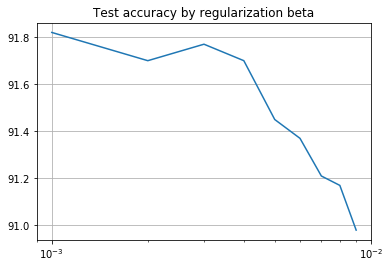

In [15]:
plt.semilogx(param, results)
plt.grid(True)
plt.title('Test accuracy by regularization beta')
plt.show()

In [16]:
param = [i for i in np.arange(1, 0.25, -0.05)]
results = []

for i in param:
    print("Dropout: %0.2f" % i)
    results.append(run_session(graph, 2000, beta=0, dropout=i, verbose=False))

Dropout: 1.00
Initialized
Test accuracy: 91.6%
Dropout: 0.95
Initialized
Test accuracy: 91.7%
Dropout: 0.90
Initialized
Test accuracy: 91.9%
Dropout: 0.85
Initialized
Test accuracy: 91.9%
Dropout: 0.80
Initialized
Test accuracy: 92.0%
Dropout: 0.75
Initialized
Test accuracy: 92.0%
Dropout: 0.70
Initialized
Test accuracy: 92.0%
Dropout: 0.65
Initialized
Test accuracy: 91.8%
Dropout: 0.60
Initialized
Test accuracy: 91.9%
Dropout: 0.55
Initialized
Test accuracy: 91.8%
Dropout: 0.50
Initialized
Test accuracy: 92.0%
Dropout: 0.45
Initialized
Test accuracy: 91.6%
Dropout: 0.40
Initialized
Test accuracy: 91.4%
Dropout: 0.35
Initialized
Test accuracy: 91.2%
Dropout: 0.30
Initialized
Test accuracy: 91.0%


In [ ]:
plt.semilogx(param, results)
plt.grid(True)
plt.title('Test accuracy by dropout keep probability')
plt.show()

In [ ]:
BATCH_SIZE = 128
HIDDEN_NODES_1 = 1024
HIDDEN_NODES_2 = 1024

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_PIXELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    l2_beta = tf.placeholder(tf.float32)  # factor for regularization penalty
    do_keep_prob = tf.placeholder(tf.float32)  # dropout keep probability
    global_step = tf.Variable(0)  # count the number of steps taken.
  
    # Variables.
    w1 = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, HIDDEN_NODES_1],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b1 = tf.Variable(tf.zeros([HIDDEN_NODES_1]))
    w2 = tf.Variable(tf.truncated_normal([HIDDEN_NODES_1, HIDDEN_NODES_2],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b2 = tf.Variable(tf.zeros([HIDDEN_NODES_2]))
    w3 = tf.Variable(tf.truncated_normal([HIDDEN_NODES_2, NUM_LABELS],
                                         stddev=1.0/np.sqrt(float(IMAGE_PIXELS))))
    b3 = tf.Variable(tf.zeros([NUM_LABELS]))
  
    # Training computation.
    hidden1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1), do_keep_prob)
    hidden2 = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden1, w2) + b2), do_keep_prob)
    logits = tf.matmul(hidden2, w3) + b3
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
            + l2_beta * (tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3))
  
    # Optimizer. 
    learning_rate = tf.train.exponential_decay(0.1, global_step, decay_steps=200, decay_rate=0.95)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    hidden1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1)
    hidden2_valid = tf.nn.relu(tf.matmul(hidden1_valid, w2) + b2)
    valid_prediction = tf.nn.softmax(tf.matmul(hidden2_valid, w3) + b3)
    hidden1_test = tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1)
    hidden2_test = tf.nn.relu(tf.matmul(hidden1_test, w2) + b2)
    test_prediction = tf.nn.softmax(tf.matmul(hidden2_test, w3) + b3)

In [ ]:
run_session(graph, 8000, beta=1e-3, dropout=0.75, verbose=True)